<a href="https://colab.research.google.com/github/cqdinh/DictionaryConceptLearning/blob/main/DictionaryConceptLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Downloading Libraries and Importing

In [1]:
!pip install pattern
!pip install gensim
!pip install num2words
!pip install transformers

     |████████████████████████████████| 22.3MB 69.4MB/s 
     |████████████████████████████████| 92kB 4.0MB/s 
     |████████████████████████████████| 81kB 11.8MB/s 
     |████████████████████████████████| 5.6MB 57.3MB/s 
     |████████████████████████████████| 5.5MB 31.0MB/s 
     |████████████████████████████████| 419kB 34.3MB/s 
     |████████████████████████████████| 3.2MB 50.3MB/s 
     |████████████████████████████████| 102kB 13.0MB/s 
  Created wheel for pattern: filename=Pattern-3.6-cp37-none-any.whl size=22332724 sha256=958997a548068ade292e1642f03f1e1499ec331e5224339fc241e22419560991
  Stored in directory: /root/.cache/pip/wheels/dc/9a/0e/5fb1a603ed4e3aa8722a88e9cf4a82da7d1b63e3d2cc34bee5
  Created wheel for mysqlclient: filename=mysqlclient-2.0.3-cp37-cp37m-linux_x86_64.whl size=100101 sha256=cc30cffa7a21e34c9338b9d5c94e758f709a906def4fea07e0dc6eb27c03e9ff
  Stored in directory: /root/.cache/pip/wheels/75/ca/e8/ad4e7ce3df18bcd91c7d84dd28c7c08db491a2a2360efed363
  Created whee

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
from sklearn.ensemble import RandomForestClassifier
import json
from gensim.models import KeyedVectors
import gensim

import tensorflow as tf
from tensorflow.keras import layers, Model, models, Input
from tensorflow import nn
import tensorflow_datasets as tfds
from random import sample

from num2words import num2words

import progressbar

import transformers

from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer
import nltk
import pattern.en as en

import re

from scipy.stats import norm

from google.colab import output

import types

%matplotlib inline

# Overall Concept

The idea of this project is to train a model to transform dictionary definitions into word embeddings, based on the fact that humans can learn new words via other people telling them what a word means i.e. "WORD is DEFINITION".

To train the transformation, dictionary definitions are retrieved from Princeton's WordNet dataset. Then, they are trained so that dictionary definitions can be mapped to Word2Vec embedding vectors.

Those embeddings are needed because children initially learn what words mean by hearing people use them. Therefore, an NLP system needs to learn the initial meanings from usage as is done to learn the Word2Vec embeddings.

Given those initial embedding vectors, it should be possible for a sytem to learn how to transform dictionary definitions into those embeddings, which will hopefully allow it to transform dictionary definitions to embeddings for new words.


# Retrieving Word2vec Embeddings

Download word2vec vectors trained on GoogleNews and load them using gensim's KeyedVectors

In [3]:
!mkdir /content/embeddings
!wget -P /content/embeddings/ -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"

--2021-03-22 03:36:29--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.46.206
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.46.206|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647046227 (1.5G) [application/x-gzip]
Saving to: ‘/content/embeddings/GoogleNews-vectors-negative300.bin.gz’

GoogleNews-vectors- 100%[===================>]   1.53G  34.8MB/s    in 46s     

2021-03-22 03:37:15 (34.3 MB/s) - ‘/content/embeddings/GoogleNews-vectors-negative300.bin.gz’ saved [1647046227/1647046227]



In [4]:
embedding_path = "/content/embeddings/GoogleNews-vectors-negative300.bin.gz"
word2vec = KeyedVectors.load_word2vec_format(embedding_path, binary=True)

word2vec["cat"]

array([ 0.0123291 ,  0.20410156, -0.28515625,  0.21679688,  0.11816406,
        0.08300781,  0.04980469, -0.00952148,  0.22070312, -0.12597656,
        0.08056641, -0.5859375 , -0.00445557, -0.296875  , -0.01312256,
       -0.08349609,  0.05053711,  0.15136719, -0.44921875, -0.0135498 ,
        0.21484375, -0.14746094,  0.22460938, -0.125     , -0.09716797,
        0.24902344, -0.2890625 ,  0.36523438,  0.41210938, -0.0859375 ,
       -0.07861328, -0.19726562, -0.09082031, -0.14160156, -0.10253906,
        0.13085938, -0.00346375,  0.07226562,  0.04418945,  0.34570312,
        0.07470703, -0.11230469,  0.06738281,  0.11230469,  0.01977539,
       -0.12353516,  0.20996094, -0.07226562, -0.02783203,  0.05541992,
       -0.33398438,  0.08544922,  0.34375   ,  0.13964844,  0.04931641,
       -0.13476562,  0.16308594, -0.37304688,  0.39648438,  0.10693359,
        0.22167969,  0.21289062, -0.08984375,  0.20703125,  0.08935547,
       -0.08251953,  0.05957031,  0.10205078, -0.19238281, -0.09

# Building a Dictionary from WordNet

This section uses the WordNet dataset to build a dictionary of the form
```
{
  word_1: [
    definition_1, 
    definition_2,
    ...
  ],
  ...
}
```

In [5]:
nltk.download("punkt")
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## The Dictionary

This class builds the dictionary and stores it in the dictionary attribute. I did this with a class instead of a function because it provides a useful way of collecting all the dictionary-building functions together.

In [7]:
class WordNetDictionary:
  def __init__(self):
    self.dictionary = dict()

    self.build_base_defns()
    self.build_morph_defns()

  # Insert a definition into the dictionary
  def add_defn(self, name, defn, pos):
    # Skip all phrases because the goal is word embeddings
    if "_" in name:
      return

    if name not in self.dictionary:
      self.dictionary[name] = set()

    defn = defn.replace('`', "'")

    self.dictionary[name].add((pos, defn))

  # Go through the synsets in WordNet and use the lemmas to build the dictionary
  def build_base_defns(self):
    bar = progressbar.ProgressBar(max_value=117659) # number of synsets
    bar.start()
    for i, synset in enumerate(wn.all_synsets()):
      bar.update(i)
      lemmas = synset.lemma_names() # Get all the words in the synset
      for lemma in lemmas:
        self.add_defn(lemma, synset.definition(), synset.pos()) # Add the synset's definition to all the lemmas

    bar.finish()


  def build_morph_defns(self):

    # Add all forms of verbs
    bar = progressbar.ProgressBar(max_value=11529) # number of verb lemmas
    bar.start()
    for i, verb in enumerate(wn.all_lemma_names("v")):
      bar.update(i)
      tenses = {
          #"inf": "Infinitive", 
          "1sg": "Present first person singular", 
          "2sg": "Present second person singular", 
          "3sg": "Present third person singular", 
          "pl": "Present plural", 
          "part": "Present Participle", 
          "p": "Past", 
          "1sgp": "Past first person singular", 
          "2sgp": "Past second person singular", 
          "3sgp": "Past third person singular", 
          "ppl": "Past plural", 
          "ppart": "Past participle"
      }
      
      for tense, tense_name in tenses.items():
        morph = en.conjugate(verb, tense)
        self.add_defn(morph, f"{tense_name} form of {verb}", "t")

    bar.finish()

    # Add plural nouns
    bar = progressbar.ProgressBar(max_value=117798) # number of noun lemmas
    bar.start()
    for i, noun in enumerate(wn.all_lemma_names("n")):
      bar.update(i)
      plural = en.pluralize(noun)
      self.add_defn(plural, f"plural form of {noun}", "p")

    bar.finish()
      

    # Add plural adjectives and both comparative (better) and superlative forms (best)
    bar = progressbar.ProgressBar(max_value=21479) # number of adjective lemmas
    bar.start()
    for i, adj in enumerate(wn.all_lemma_names('a')):
      bar.update(i)
      plural = en.pluralize(adj)
      if plural != adj:
        self.add_defn(plural, f"plural form of {adj}", "q")

      comp = en.comparative(adj)

      self.add_defn(comp, f"comparative form of {adj}", "c")

      sup = en.superlative(adj)

      self.add_defn(comp, f"superlative form of {adj}", "m")
    
    bar.finish()


    # Add plural, comparative, and superlatvie forms of adjective satellites, which are basically just adjectives
    bar = progressbar.ProgressBar(max_value=21479) # number of adjective satellite lemmas
    bar.start()

    for i, adj_sat in enumerate(wn.all_lemma_names('s')):
      bar.update(i)
      plural = en.pluralize(adj_sat)
      if plural != adj_sat:
        self.add_defn(plural, f"plural form of {adj_sat}", "q")

      comp = en.comparative(adj_sat)

      self.add_defn(comp, f"comparative form of {adj_sat}", "comparative")

      sup = en.superlative(adj_sat)

      self.add_defn(comp, f"superlative form of {adj_sat}", "m")

    bar.finish()

  '''def build_phrase_morph_defns(self):
    print(len([x for x in self.dictionary.keys() if x.split() > 1]))

    for key in self.dictionary.keys():
      words = key.split()
      if len(words) > 1:
        tenses = {
          #"inf": "Infinitive", 
          "1sg": "Present first person singular", 
          "2sg": "Present second person singular", 
          "3sg": "Present third person singular", 
          "pl": "Present plural", 
          "part": "Present Participle", 
          "p": "Past", 
          "1sgp": "Past first person singular", 
          "2sgp": "Past second person singular", 
          "3sgp": "Past third person singular", 
          "ppl": "Past plural", 
          "ppart": "Past participle"
        }

        is_verb = [any("v" == synset.pos() for synset in wn.synsets(word)) for word in words]

        if not any(is_verb):
          continue

        for tense in tenses:
          for tense, tense_name in tenses.items():
            morph = [pattern.en.conjugate(word, tense) if iv else word for word, iv in zip(words, is_verb)]
            self.add_defn(" ".join(morph), f"{tense_name} form of {verb}", "tense")'''


# Build the dictionary
wnd = WordNetDictionary()

wnd.dictionary

100% (117659 of 117659) |################| Elapsed Time: 0:00:02 Time:  0:00:02
100% (11529 of 11529) |##################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (117798 of 117798) |################| Elapsed Time: 0:00:04 Time:  0:00:04
100% (21479 of 21479) |##################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (21479 of 21479) |##################| Elapsed Time: 0:00:01 Time:  0:00:01


{'able': {('a',
   "(usually followed by 'to') having the necessary means or skill or know-how or authority to do something"),
  ('s', 'have the skills and qualifications to do things well'),
  ('s', 'having a strong healthy body'),
  ('s', 'having inherent physical or mental ability or capacity')},
 'unable': {('a',
   "(usually followed by 'to') not having the necessary means or skill or know-how"),
  ('s',
   "(usually followed by 'to') lacking necessary physical or mental ability"),
  ('s', 'lacking in power or forcefulness')},
 'abaxial': {('a', 'facing away from the axis of an organ or organism')},
 'dorsal': {('a',
   'belonging to or on or near the back or upper surface of an animal or organ or part'),
  ('a', 'facing away from the axis of an organ or organism')},
 'adaxial': {('a',
   'nearest to or facing toward the axis of an organ or organism')},
 'ventral': {('a',
   'nearest to or facing toward the axis of an organ or organism'),
  ('a',
   'toward or on or near the belly

# Vocabulary Sets

There are two relevant sets of words: The words in Word2Vec and the words in WordNet. 

During training, only the words in both sets can have the model trained to map their definitions to their embeddings. However, the definitions include many other words, so those words need to have their embeddings generated.

Words in the definitions which are also in WordNet can be assigned the embeddings produced by the model from their definitions.

Words in the definitions which are only in Word2Vec can get their embeddings that way.

Any words in neither set can have their embeddings trained directly.

In [ ]:
w2v_vocab = set(word2vec.vocab.keys())
wnd_vocab = set(wnd.dictionary.keys())
trainable_vocab = w2v_vocab.intersection(wnd_vocab)
vocab_to_build = wnd_vocab - w2v_vocab
vocab = wnd_vocab.union(w2v_vocab)



    
definition_words = set()
total_len = 0
not_found_count = 0
not_found_definitions = {word: set() for word in wnd.dictionary.keys()}

bar = progressbar.ProgressBar(max_value=len(wnd.dictionary)) # number of adjective satellite lemmas
bar.start()
for i, (word, defns) in enumerate(wnd.dictionary.items()):
  bar.update(i)
  for pos, defn in defns:
    for match in re.finditer("'[a-zA-Z]*'", defn):
      start, end = match.span()
      defn = defn[:start] + '"' + defn[start+1:end-1] + '"' + defn[end:]

    defn = defn.replace("_", " ")
    defn = defn.replace("-", " - ")

    definition_words = definition_words | set(tokenize(defn))

bar.finish()

len(vocab), len(vocab_to_build), len(definition_words), len(definition_words-vocab)

In [ ]:
def tokenize(text):
  tokens = nltk.tokenize.word_tokenize(text)
  result = []
  for i in range(len(tokens)):
    if tokens[i] == "inf":
      result.append("infinity")
      continue
    elif tokens[i] == "infinity":
      result.append("infinity")
      continue
    try:
      numerical = float(tokens[i])
      words = num2words(numerical)
      words = words.replace("-", " - ")
      result = result + nltk.tokenize.word_tokenize(words)

    except ValueError:
      result.append(tokens[i])

  return result

class EmbeddingProcessor(models.Model):
  def __init__(self, word2vec, wordnet_dict):
    word2vec_vocab = set(word2vec.vocab.keys())
    wordnet_vocab = set(wordnet_dict.keys())

    # Start with the words in both Word2Vec and WordNet
    words = list(sorted(word2vec_vocab & wordnet_vocab))

    # These embeddings are pulled from Word2Vec and aren't trained since that would likely cause catastrophic forgetting
    word2vec_vocab = {word: i for i, word in enumerate(words)}
    word2vec_embeddings = np.array([word2vec[word] for word in words])
    self.word2vec_embeddings = layers.Embedding(word2vec_embeddings.shape[0], word2vec_embeddings.shape[1])
    self.word2vec_embeddings.embeddings.assign(word2vec_embeddings)
    self.word2vec_embeddings.trainable = False

    # 
    wordnet_vocab = dict()
    neither_vocab = dict()
    for i, word in enumerate(sorted(wordnet_dict.keys())):
      if word not in word2vec_vocab:
        wordnet_vocab[word] = i
        words.append(word)
    for word, defns in wordnet_dict.items():
      for defn in defns:
        for match in re.finditer("'[a-zA-Z]*'", defn):
          start, end = match.span()
          defn = defn[:start] + '"' + defn[start+1:end-1] + '"' + defn[end:]

        defn = defn.replace("_", " ")
        defn = defn.replace("-", " - ")

        for defn_word in tokenize(defn):
          if defn_word not in word2vec_vocab and defn_word not in wordnet_vocab:
            neither_vocab[defn_word] = len(neither_vocab)
            words.append(defn_word)
    
    self.word_indices = {word:i for i, word in enumerate(words)}

    

    self.word2vec_embeddings = 

  def to_ints(self, words):
    return [self.word_indices[word] for word in words]

  def call(self, x):


defn -> tokens

tokens -> stored word embeddings
  For words that only have a wordnet definition, use the embedding generated by the definitions -> embedding model
  For unknown words, initialize with a random embedding

model(tokens) -> definition embedding

model(tokens) for defn in defns -> definition embeddings

attention_model(embeddings) -> word embedding

Training:

If the word has a word2vec embedding, train towards that directly

The embeddings of wordnet-only words are treated as trainable variables and optimized along with the parameters of the model.
  Then, the model is trained to approximate the optimized embeddings, pretending that they are word2vec embeddings.

The embeddings of words that have no definitions or embedding vectors are directly treated as trainable variables

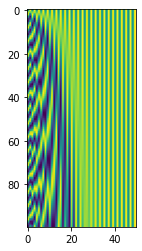

In [ ]:
def build_position_encoding(max_pos, dim):
  i = np.arange(dim // 2)
  denominator = np.power(10000, 2 * i / dim)

  pos = np.arange(max_pos).reshape(-1, 1)

  vals = pos / denominator

  sin = np.sin(vals)
  cos = np.cos(vals)

  res = np.zeros((max_pos, dim))

  res[:,::2] = sin

  res[:,1::2] = cos

  return res

plt.imshow(build_position_encoding(100, 50))

In [ ]:
class CombiningAttention(layers.Layer):
  def __init__(self):
    super().__init__()
    self.scorer = layers.Dense(1)
    self.softmax = layers.Softmax(axis=-2)

  def call(self, x):
    scores = self.scorer(x)

    scores = self.softmax(scores)

    weighted = tf.matmul(x, scores, transpose_a=True)

    weighted = tf.squeeze(weighted, axis=-1)

    return weighted

class PositionalEncoder(layers.Layer):
  def __init__(self, n_tokens):
    super().__init__()
    self.n_tokens = n_tokens

  def build(self, input_shape):
    self.encodings = tf.Variable(build_position_encoding(self.n_tokens, input_shape[-1]), dtype=tf.float32, trainable=False)

  def call(self, x):
    return x + self.encodings

class TransformerEncoder(layers.Layer):
  def __init__(self, n_heads):
    super().__init__()
    self.n_heads = n_heads

  def build(self, input_shape):
    hidden_size = input_shape[-1]
    self.attn = layers.MultiHeadAttention(self.n_heads, hidden_size)
    self.layernorm_1 = layers.LayerNormalization()
    self.dense_1 = layers.Dense(hidden_size)
    self.lrelu_1 = layers.LeakyReLU()
    self.dense_2 = layers.Dense(hidden_size)
    self.lrelu_2 = layers.LeakyReLU()
    self.layernorm_2 = layers.LayerNormalization()
  
  def call(self, x):
    attn = self.attn(x, x)
    x = self.layernorm_1(x + attn)
    dense = self.dense_1(x)
    dense = self.lrelu_1(dense)
    dense = self.dense_2(dense)
    dense = self.lrelu_2(dense)
    return self.layernorm_2(x + dense)

def DefinitionEmbedder(n_tokens, embedding_size, n_heads, n_layers):
  embedder_layers = [
      Input((n_tokens, embedding_size))
  ]

  for i in range(n_layers):
    embedder_layers.append(TransformerEncoder(n_heads))
  
  embedder_layers += [
      CombiningAttention(),
      layers.Dense(embedding_size),
      layers.LeakyReLU(),
      layers.Dense(embedding_size)
  ]

  return models.Sequential(embedder_layers)

tf.keras.backend.clear_session()

n_tokens = 128
embedding_size = 300

model = DefinitionEmbedder(n_tokens, embedding_size, 8, 3)

test_input = np.random.normal(size=(10, n_tokens, 300))

out = model(test_input)

print(out.shape)

model.summary()

(10, 300)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
transformer_encoder (Transfo (None, 128, 300)          3069300   
_________________________________________________________________
transformer_encoder_1 (Trans (None, 128, 300)          3069300   
_________________________________________________________________
transformer_encoder_2 (Trans (None, 128, 300)          3069300   
_________________________________________________________________
combining_attention (Combini (None, 300)               301       
_________________________________________________________________
dense_1 (Dense)              (None, 300)               90300     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 300)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 300)      

In [ ]:
combiner_model = models.Sequential([
  Input((None, 300)),
  layers.Dense(300),
  layers.LeakyReLU(),
  CombiningAttention(),
  layers.Dense(300)
])

combined = combiner_model(tf.expand_dims(out, 0))

print(combined.shape)

combiner_model.summary()

(1, 300)
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, None, 300)         90300     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, None, 300)         0         
_________________________________________________________________
combining_attention_1 (Combi (None, 300)               301       
_________________________________________________________________
dense_5 (Dense)              (None, 300)               90300     
Total params: 180,901
Trainable params: 180,901
Non-trainable params: 0
_________________________________________________________________


In [ ]:
len(w2v_vocab)

3000000

In [ ]:
training_dict = {}

for word in trainable_vocab:
  word: wnd.dictionary[word] for word in trainable_vocab

training_dict

{'tun': {('n',
   'a large cask especially one holding a volume equivalent to 2 butts or 252 gals')},
 'destructed': {('t', 'Past first person singular form of destruct'),
  ('t', 'Past form of destruct'),
  ('t', 'Past participle form of destruct'),
  ('t', 'Past plural form of destruct'),
  ('t', 'Past second person singular form of destruct'),
  ('t', 'Past third person singular form of destruct')},
 'perplexed': {('a', 'full of difficulty or confusion or bewilderment'),
  ('t', 'Past first person singular form of perplex'),
  ('t', 'Past form of perplex'),
  ('t', 'Past participle form of perplex'),
  ('t', 'Past plural form of perplex'),
  ('t', 'Past second person singular form of perplex'),
  ('t', 'Past third person singular form of perplex')},
 'endotoxin': {('n',
   'a toxin that is confined inside the microorganisms and is released only when the microorganisms are broken down or die')},
 'stows': {('t', 'Present third person singular form of stow')},
 'doppelganger': {('n',


In [ ]:
word2vec["UNK"]

array([-9.47265625e-02, -5.11718750e-01,  5.81054688e-02,  5.07812500e-01,
       -1.20117188e-01, -4.19921875e-01,  3.32031250e-02,  1.54296875e-01,
       -2.44140625e-01,  1.47460938e-01, -1.20239258e-02,  8.74023438e-02,
        7.42187500e-02,  2.53906250e-01,  3.06640625e-01, -1.28906250e-01,
        1.00097656e-01, -1.85546875e-01,  9.66796875e-02, -3.73046875e-01,
       -2.34985352e-03,  1.26342773e-02,  2.40478516e-02,  3.06640625e-01,
       -2.73437500e-01, -8.74023438e-02,  1.14257812e-01,  1.94335938e-01,
       -2.22656250e-01,  1.10839844e-01,  6.88476562e-02, -7.56835938e-02,
        2.63671875e-01, -3.80859375e-01,  2.41210938e-01, -4.27246094e-02,
       -2.99072266e-02, -1.56250000e-01,  2.01171875e-01,  3.49609375e-01,
        3.06640625e-01, -3.35937500e-01, -1.48437500e-01,  2.53906250e-01,
       -4.29687500e-02,  1.50390625e-01, -1.97753906e-02, -1.96289062e-01,
        3.26171875e-01,  2.48046875e-01, -1.85546875e-01, -3.65234375e-01,
       -2.71484375e-01, -

In [ ]:
tokenized_training_dict = {word: [[pos] + tokenize(defn) for pos, defn in defns] for word, defns in training_dict.items()}
tokenized_training_dict

{'tun': [['n',
   'a',
   'large',
   'cask',
   'especially',
   'one',
   'holding',
   'a',
   'volume',
   'equivalent',
   'to',
   'two',
   'butts',
   'or',
   'two',
   'hundred',
   'and',
   'fifty',
   '-',
   'two',
   'gals']],
 'destructed': [['t',
   'Past',
   'first',
   'person',
   'singular',
   'form',
   'of',
   'destruct'],
  ['t', 'Past', 'third', 'person', 'singular', 'form', 'of', 'destruct'],
  ['t', 'Past', 'participle', 'form', 'of', 'destruct'],
  ['t', 'Past', 'plural', 'form', 'of', 'destruct'],
  ['t', 'Past', 'form', 'of', 'destruct'],
  ['t', 'Past', 'second', 'person', 'singular', 'form', 'of', 'destruct']],
 'perplexed': [['a',
   'full',
   'of',
   'difficulty',
   'or',
   'confusion',
   'or',
   'bewilderment'],
  ['t', 'Past', 'plural', 'form', 'of', 'perplex'],
  ['t', 'Past', 'third', 'person', 'singular', 'form', 'of', 'perplex'],
  ['t', 'Past', 'first', 'person', 'singular', 'form', 'of', 'perplex'],
  ['t', 'Past', 'participle', 'form'

In [ ]:
padded_training_dict = {}

for word, defns in tokenized_training_dict:
  

98

In [ ]:
def run_model(definitions, embedding_model, attention_model, word2vec, training_embeddings, pos_embeddings, word2vec_vocab, wordnet_vocab, dictionary, curr_word=None, parent_words=None):
  defn_embeddings = []
  for pos, defn in definitions:
    if pos not in pos_embeddings:
      pos_embeddings[pos] = np.random.normal(0, 0.12, 300)
    pos_embed = pos_embeddings[pos]
    words = tokenize(defn)
    embeddings = []
    for word in words:
      if word in word2vec_vocab:
        embeddings.append(word2vec[word])
      else:
        lower = word.lower()
        if lower not in training_embeddings:
          # Break infinite recursion
          if curr_word is not None and lower == curr_word or parent_words is not None and lower in parent_words:
            print("broke cycle:", lower, curr_word, parent_words)
            return np.random.normal(0, 0.12, 300)
          
          if lower in wordnet_vocab:
            if parent_words is None:
              parent_words = []
            else:
              parent_words = parent_words[:]
            if curr_word is not None:
              parent_words.append(curr_word)
            word_embed = run_model(dictionary[lower], embedding_model, attention_model, word2vec, training_embeddings, pos_embeddings, word2vec_vocab, wordnet_vocab, dictionary, word, parent_words)
            training_embeddings[lower] = word_embed
          else:
            training_embeddings[lower] = np.random.normal(0, 0.12, 300)

        embeddings.append(training_embeddings[lower])
    embeddings = np.stack(embeddings, axis=0)
    embeddings = np.expand_dims(embeddings, axis=0)
    defn_embed = embedding_model(embeddings)
    defn_embeddings.append(defn_embed)

  defn_embeddings = np.stack(defn_embeddings, axis=1)
  return attention_model(defn_embeddings).numpy()[0]

embeddings = dict()
pos_embeddings = dict()

run_model(wnd.dictionary["able"], model, combiner_model, word2vec, embeddings, pos_embeddings, w2v_vocab, wnd_vocab, wnd.dictionary)

array([ 3.82367871e-05,  1.02356717e-06,  4.09092427e-05, -4.42359305e-05,
       -1.72344971e-05, -1.44821624e-05,  2.31666454e-05,  1.47416513e-05,
        2.69190441e-05,  5.45529074e-05, -2.74966969e-05, -4.48463252e-05,
       -1.72158143e-05,  5.33998355e-05, -7.24853726e-06, -1.64265093e-05,
        4.07211301e-05,  2.61909499e-05, -5.36147127e-06, -7.79582570e-06,
       -3.11896147e-05,  2.04054595e-06, -7.87319823e-06,  4.23137026e-05,
        2.08635265e-05,  1.76499052e-05,  2.06926161e-05, -2.67853557e-06,
       -2.09602308e-06, -3.45440731e-06, -1.78906648e-05, -2.90379103e-06,
       -8.77425737e-06,  4.31345179e-05, -2.97070619e-06, -4.18086711e-05,
        3.37635138e-05, -1.61157695e-05, -1.95711582e-05,  4.00136050e-05,
       -4.18977106e-06,  7.45690704e-06,  1.23558075e-05, -8.19811066e-06,
       -1.28618485e-05,  5.64990842e-07,  3.08978542e-07, -2.80944168e-05,
       -1.46804450e-06, -1.82013428e-05,  2.26025713e-05, -4.39408541e-05,
        7.17094190e-06, -

In [ ]:
not_found_words

{'Ratibida',
 'hepin',
 'vesalius',
 '1/100th',
 'leptoptilus',
 'stieglitz',
 'msh',
 'metternich',
 'helvetica',
 'kaochlor',
 'pisces',
 'Iditarod',
 'volund',
 'yahwe',
 'Insectivora',
 'connors',
 'cunoniaceae',
 'sukarno',
 'Ephippidae',
 'polemoniaceae',
 'smitane',
 'gerbert',
 'schopenhauer',
 'poecilocapsus',
 'aegilops',
 'heimdallr',
 'hejaz',
 'Ercilla',
 'hepaticopsida',
 'houghton',
 'philemon',
 'tarsiidae',
 'teiidae',
 'vangueria',
 'kursk',
 'avicenniaceae',
 'volgograd',
 'nuytsia',
 'hyalosperma',
 'squalidae',
 'seeland',
 'cryptogamia',
 'rosellinia',
 'wykeham',
 'pekingese',
 'pythoninae',
 'menotyphla',
 'llullaillaco',
 'mitford',
 'paleocene',
 'svedberg',
 'Peritrate',
 'scombresox',
 'balaenopteridae',
 'channukkah',
 'olympus',
 'Krupp',
 'hybanthus',
 'cyamus',
 'symphyla',
 'pyxidanthera',
 'cuniculus',
 'Apogonidae',
 'bombina',
 'naziism',
 'Epicurus',
 'estonia',
 'staphylinidae',
 'hammarskjold',
 'piptadenia',
 'nlrb',
 'chlamydomonas',
 'myrrhis',

In [ ]:
embeddings = {word: np.random.normal(0, 0.12, 300) for word in wnd_vocab.union(not_found_words)}
pos_embeddings = dict()

In [ ]:
def run_batch(words, optimizer, embedding_model, attention_model, word2vec, training_embeddings, pos_embeddings, word2vec_vocab, wordnet_vocab, dictionary):
  # Figure out which embeddings need to be trained along with the model

  words_to_train = dict()
  embeddings_to_train = []
  targets = []
  pos_to_train = dict()
  pos_embeddings_to_train = []
  for word in words:
    for pos, defn in dictionary[word]:
      if pos not in pos_to_train:
        pos_to_train[pos] = len(pos_to_train)
        if pos not in pos_embeddings:
          pos_embeddings[pos] = np.random.normal(0, 0.12, 300)
        pos_embeddings_to_train.append(pos_embeddings[pos])

      for defn_word in tokenize(defn):
        if defn_word not in word2vec_vocab:
          lower = defn_word.lower()
          if lower not in words_to_train:
            words_to_train[lower] = len(words_to_train)
            
            if lower not in training_embeddings:
              if lower in wordnet_vocab:
                training_embeddings[lower] = run_model(dictionary[lower], embedding_model, attention_model, word2vec, training_embeddings, pos_embeddings, word2vec_vocab, wordnet_vocab, dictionary)
              else:
                training_embeddings[lower] = np.random.normal(0, 0.12, 300)
            
            embeddings_to_train.append(training_embeddings[lower])

  # Do the gradient descent
  pos_embeddings_to_train = tf.Variable(tf.convert_to_tensor(pos_embeddings_to_train, dtype=tf.float32), trainable=True)
  embeddings_to_train = tf.Variable(tf.convert_to_tensor(embeddings_to_train, dtype=tf.float32), trainable=True)
  targets = [tf.convert_to_tensor(target) for target in targets]
  training_embeddings_update = dict()
  with tf.GradientTape() as tape:
    loss = None
    for word in words:
      if word in word2vec_vocab:
        target = word2vec[word]

      else:
        target = training_embeddings[word.lower()]

      target = tf.convert_to_tensor(target)

      defn_embeddings = []
      for pos, defn in dictionary[word]:
        pos_embed = pos_embeddings_to_train[pos_to_train[pos]]
        word_embeddings = [pos_embed]

        for defn_word in tokenize(defn):
          if defn_word in word2vec_vocab:
            word_embeddings.append(tf.convert_to_tensor(word2vec[defn_word]))
          else:
            word_embeddings.append(embeddings_to_train[words_to_train[defn_word.lower()]])

        word_embeddings = tf.stack(word_embeddings, axis=0)
        word_embeddings = tf.expand_dims(word_embeddings, axis=0)
        
        defn_embeddings.append(embedding_model(word_embeddings))

      defn_embeddings = tf.stack(defn_embeddings, axis=1)
      pred_embedding = attention_model(defn_embeddings)

      if word not in word2vec_vocab and word not in words_to_train:
        training_embeddings_update[word] = pred_embedding.numpy()

      error = pred_embedding - target
      error = error * error
      error = tf.reduce_mean(error)

      if loss is None:
        loss = error
      else:
        loss = loss + error

    # Average over the batch
    loss = loss / len(words)

  variables = embedding_model.trainable_variables + attention_model.trainable_variables
  variables.append(embeddings_to_train)
  variables.append(pos_embeddings_to_train)

  grads = tape.gradient(loss, variables)
  optimizer.apply_gradients(zip(grads, variables))

  # Update the trained embeddings
  for word, index in words_to_train.items():
    training_embeddings[word] = embeddings_to_train[index].numpy()

  for pos, index in pos_to_train.items():
    pos_embeddings[pos] = pos_embeddings_to_train[index].numpy()

  return float(loss)

epochs = 1
batch_size = 5
learning_rate = 1e-3
shuffle = True

words = np.array(list(sorted(trainable_vocab)))
order = np.arange(len(words))

opt = tf.keras.optimizers.Adam(lr=learning_rate)

for epoch in range(epochs):
  if shuffle:
    np.random.shuffle(order)

  batches = len(words) // batch_size
  losses = []

  bar = progressbar.ProgressBar(max_value=batches) # number of adjective satellite lemmas
  bar.start()
  
  for i, batch_start in enumerate(range(0, len(words), batch_size)):
    bar.update(i)
    batch_words = words[order[batch_start:batch_start+batch_size]]
    loss = run_batch(batch_words, opt, model, combiner_model, word2vec, embeddings, pos_embeddings, w2v_vocab, wnd_vocab, wnd.dictionary)
    losses.append(loss)

  bar.finish()

  print("Average Loss:", np.mean(losses))

100% (17251 of 17251) |##################| Elapsed Time: 1:46:00 Time:  1:46:00


Average Loss: 0.08409909530178511


In [ ]:
def cos(a,b):
  return np.sum(a*b) / (np.linalg.norm(a) * np.linalg.norm(b))

In [ ]:
both_words = wnd_vocab.intersection(w2v_vocab)
both_words

{'albacore',
 'INR',
 'capitulation',
 'leakages',
 'trifling',
 'suburban',
 'unsavory',
 'EDTA',
 'grudged',
 'straightaways',
 'speciously',
 'amplifier',
 'goldsmiths',
 'whorled',
 'allege',
 'craggier',
 'relieving',
 'grandpa',
 'degenerative',
 'Aeolis',
 'clearway',
 'breeziness',
 'thumbprint',
 'clop',
 'Bristol',
 'mutter',
 'Lepas',
 'palpitating',
 'footmarks',
 'announcement',
 'dockhand',
 'bigos',
 'stultification',
 'institutionalises',
 'highlighter',
 'acrostics',
 'microsomes',
 'underslung',
 'caldera',
 'ceilinged',
 'cesspools',
 'judgment',
 'litterer',
 'rumps',
 'raphe',
 'shallow',
 'lyres',
 'ceilings',
 'potholes',
 'chronically',
 'pelota',
 'mosquito',
 'commissioner',
 'gainers',
 'uncooked',
 'quadruplicate',
 'blandly',
 'providentially',
 'expending',
 'scriptorium',
 'Blackburn',
 'transcultural',
 'Elavil',
 'effort',
 'seduced',
 'wannabes',
 'laparoscope',
 'incurring',
 'Tevere',
 'pushers',
 'dialectal',
 'salivation',
 'sophomore',
 'gunlocks'

In [ ]:
dist = dict()

bar = progressbar.ProgressBar(max_value=batches) # number of adjective satellite lemmas
bar.start()

for i, word in enumerate(both_words):
  bar.update(i)
  sim = cos(word2vec[word], run_model(wnd.dictionary[word], model, combiner_model, word2vec, embeddings, pos_embeddings, w2v_vocab, wnd_vocab, wnd.dictionary))
  dist[word] = sim

bar.finish()



dist

100% (17251 of 17251) |##################| Elapsed Time: 0:11:23 ETA:  00:00:00

ValueError: ignored

In [ ]:
dist

NameError: ignored

In [ ]:
np.mean(dist.values())

In [ ]:
losses

NameError: ignored

In [ ]:
x = tf.Variable(np.random.normal(size=(5,10)))
opt = tf.keras.optimizers.Adam(lr=1)
with tf.GradientTape() as tape:
  loss = None

  for i in range(5):
    target = tf.convert_to_tensor(np.random.normal(size=10))

    err = x[i] - target

    err = err * err

    err = tf.reduce_mean(err)

    if loss is None:
      loss = err

    else:
      loss = loss + err
  loss = loss / 5

print(float(loss))
print(x)

grads = tape.gradient(loss, [x])
opt.apply_gradients(zip(grads, [x]))

x.numpy()

1.6150030021657726
<tf.Variable 'Variable:0' shape=(5, 10) dtype=float64, numpy=
array([[-0.51266952, -0.52724884,  0.37630061, -0.25947511,  0.14654545,
        -0.18883677, -0.90092532, -1.15599822, -0.24126746, -2.34141656],
       [-1.20307202,  0.10874393,  2.04896699,  0.22521563, -2.17134716,
        -0.42730027, -1.41542255, -0.47428344, -0.11645452, -0.33603588],
       [-0.67576077, -1.68692104, -0.48841915, -1.42040961, -0.60588185,
        -1.12757403,  1.80373216, -0.84342079, -1.56772448,  0.29234222],
       [ 0.45000398,  0.23346139, -2.1326768 , -0.17831778,  0.77181729,
         1.13899272, -0.39766471,  0.19491102, -0.90625291, -0.302657  ],
       [ 2.35612979,  0.9536497 ,  0.1352557 ,  0.14821337,  0.36137429,
         0.78930099, -0.42189003,  0.78875613,  2.13275098,  0.49964952]])>


array([[-1.51248703, -1.52710409,  1.37625099, -1.25704565, -0.85333518,
        -1.18876131,  0.09900854, -0.15603973,  0.75868188, -1.34144566],
       [-0.20314924,  1.10836963,  1.04914686, -0.7747313 , -1.17137975,
         0.57018927, -2.41519513, -1.47417498,  0.88334412, -1.33529688],
       [-1.67184126, -0.68696186,  0.51153073, -0.42068227,  0.39274964,
        -0.12763923,  0.80469709,  0.15645486, -0.56774961, -0.70759769],
       [-0.54991117, -0.76634533, -1.13270708,  0.82161291, -0.22787977,
         0.13904629,  0.60229772, -0.80501581, -1.90618556,  0.69670033],
       [ 1.35621918, -0.04626561, -0.86469534,  1.14729722, -0.63776904,
        -0.21061789,  0.57799421, -0.21120364,  1.13280656, -0.50028171]])

In [ ]:
type(mdl.trainable_variables)

list

In [ ]:
not_found_words

{'yib',
 'Mobulidae',
 'rolf',
 'picumnus',
 'myxiniformes',
 'maleseet',
 'crassulaceae',
 'Calamintha',
 'pokomo',
 'anisotremus',
 'sphacele',
 'coffea',
 'orwellian',
 'mirounga',
 'Thunnus',
 'cornishman',
 'thamnophilus',
 'astrophyton',
 'Moraceae',
 'yuman',
 'gauri',
 'zygnemales',
 'lastex',
 'nilsson',
 'tuchman',
 'berteroa',
 'newburgh',
 'Oruvail',
 "'to",
 'abidjan',
 'araneus',
 'prionotus',
 'macrodantin',
 'corvidae',
 'Antilles',
 'Reptilia',
 'muscivora',
 'sacagawea',
 'taleban',
 'mccullers',
 'Monodontidae',
 'Pandanales',
 'ojibwa',
 'alouatta',
 'Agrippa',
 'pyralidae',
 'wodan',
 'dubyuh',
 'Christendom',
 'prokhorov',
 'Steiner',
 'ssri',
 'stendhal',
 'elops',
 'Symplocaceae',
 'psilopsida',
 'alternanthera',
 'inuit',
 'acanthocybium',
 'scomberomorus',
 'borodino',
 'cacatua',
 'lampyridae',
 'Vancocin',
 'Herzegovina',
 'aleut',
 'edaphosauridae',
 'nuwc',
 'buxus',
 'Broca',
 'cva',
 'Yorktown',
 'namoi',
 'acanthaceae',
 'lo/ovral',
 'gentiana',
 '750,0

In [ ]:
letters = set(list("abcdefghijklmnopqrstuvwxyz_"))

[x for x in w2v_vocab if x[0] != "#" and len(set(list(x)) - letters)]

['Lucy_de_Groot',
 'Johnny_Janosik',
 'sporty_A4',
 'Seegal',
 'Tracey_Schelmetic',
 'Akinbule',
 'Malinowska',
 'Missaukee_County',
 'David_Dapice',
 'Hu_Jia',
 'Nevada_Interscholastic_Activities',
 'wide_receiver_Juron_Criner',
 'Newarthill',
 'Titrinote',
 'Fiserv_Aperio',
 'Alamieyeseigha',
 'SAAW',
 'Convicted',
 'Ishay_Davidi',
 'OPEN_HOUSE_AND',
 'Pete_Savagian_engineering',
 'Beachaven',
 'MADRS',
 'INSPIRE_PHARMACEUTICALS',
 'Bruchhagen',
 'Flintshire_Chronicle',
 'Gregoris',
 'coast_XETA',
 'Seema_Mehta_Times',
 'Violet_Seboni',
 'Xenadrine_EFX',
 'David_Choquehuanca',
 'Mahela_Udawatte',
 'Viradouro_samba',
 'Intervet_Schering_Plough',
 'Beiro',
 'Kanyomozi',
 'Bannett',
 'Kangaru',
 'Wolfowitz_Feith',
 'spokeswoman_Victoria_Lupica',
 'BRAC_commissioners',
 'Youâ_€_™',
 "WE_'RE_NO",
 'Suning_######.SZ',
 'Enforce_Immigration',
 'SVS_Vision',
 'TOOELE_COUNTY',
 'Geat',
 'Tule',
 'ICS_COPPER_SYSTEMS_LTD',
 'Ketring',
 'Repast',
 'UPS.N_行情',
 'SKorea',
 'Mike_Jaconette',
 'VIDA

In [ ]:
wnd.dictionary["to"]

KeyError: ignored

In [ ]:
word2vec["UNK"]

array([-9.47265625e-02, -5.11718750e-01,  5.81054688e-02,  5.07812500e-01,
       -1.20117188e-01, -4.19921875e-01,  3.32031250e-02,  1.54296875e-01,
       -2.44140625e-01,  1.47460938e-01, -1.20239258e-02,  8.74023438e-02,
        7.42187500e-02,  2.53906250e-01,  3.06640625e-01, -1.28906250e-01,
        1.00097656e-01, -1.85546875e-01,  9.66796875e-02, -3.73046875e-01,
       -2.34985352e-03,  1.26342773e-02,  2.40478516e-02,  3.06640625e-01,
       -2.73437500e-01, -8.74023438e-02,  1.14257812e-01,  1.94335938e-01,
       -2.22656250e-01,  1.10839844e-01,  6.88476562e-02, -7.56835938e-02,
        2.63671875e-01, -3.80859375e-01,  2.41210938e-01, -4.27246094e-02,
       -2.99072266e-02, -1.56250000e-01,  2.01171875e-01,  3.49609375e-01,
        3.06640625e-01, -3.35937500e-01, -1.48437500e-01,  2.53906250e-01,
       -4.29687500e-02,  1.50390625e-01, -1.97753906e-02, -1.96289062e-01,
        3.26171875e-01,  2.48046875e-01, -1.85546875e-01, -3.65234375e-01,
       -2.71484375e-01, -

In [ ]:
word2vec["n't"]

array([-1.10351562e-01,  3.12500000e-01, -3.73046875e-01,  7.42187500e-02,
       -8.59375000e-02, -3.56445312e-02,  4.60815430e-03,  5.10253906e-02,
       -2.01171875e-01,  1.54418945e-02, -1.93359375e-01, -6.01562500e-01,
       -2.40234375e-01, -2.70996094e-02, -3.83300781e-02,  1.41601562e-01,
        1.53808594e-02,  1.38671875e-01,  4.37011719e-02, -1.55273438e-01,
       -1.78710938e-01, -2.52685547e-02,  1.25122070e-02,  5.76171875e-02,
        4.63867188e-03,  2.32421875e-01, -3.47656250e-01,  2.49023438e-01,
       -1.79443359e-02, -1.47460938e-01, -1.32812500e-01,  2.33398438e-01,
        5.02929688e-02, -1.59179688e-01, -3.94531250e-01,  1.95312500e-01,
       -2.43164062e-01,  1.27929688e-01,  1.36718750e-01, -1.57226562e-01,
        1.15356445e-02,  2.91015625e-01,  3.96484375e-01,  3.95507812e-02,
        1.31835938e-01, -2.30468750e-01,  5.49316406e-02, -6.54296875e-02,
       -2.73437500e-01,  2.16796875e-01,  6.54296875e-02, -7.32421875e-02,
        5.39550781e-02,  

In [ ]:
wn.synsets("of")

[]

In [ ]:
wnd.dictionary["of"]

KeyError: ignored

Definition -> embedding

definition -> array of words -> embeddings for each word -> transformer encoder -> attention -> definition embedding

word has definitions

definitions -> definition embeddings -> attention -> word embedding

In [ ]:
synsets = np.array(list(wn.all_synsets()))


epochs = 100
batches_per_epoch = 100
embed_size = 128
batch_size = 150
lr = 1e-2



embeddings = layers.Embedding(117659, embed_size)

opt = tf.keras.optimizers.SGD(learning_rate=lr)

for epoch in range(epochs):
  for batch_n in range(batches_per_epoch):
    sample_a = np.random.randint(0, len(synset), batch_size)
    sample_b = np.random.randint(0, len(synset), batch_size)
    synset_a = synsets[sample_a]
    embed_a = embeddings(sample_a)
    synset_b = synsets[sample_b]
    embed_b = embeddings(sample_b)

    true_cos = [A.path_similarity(B) for A, B in zip(synset_a, synset_b)]

    for A, B in zip(synset_a, synset_b):
      print(A, B)
      print(A.path_similarity(B))

    print(true_cos)

    x = 1/0

    with tf.GradientTape() as tape:
      tape.watch(embeddings.trainable_variables)
      

      pred_cos = tf.keras.losses.cosine_similarity(embed_a, embed_b)

      err = true_cos - pred_cos

      err = tf.reduce_mean(err * err)

    print(err.numpy())

    grad = tape.gradient(err, embeddings.trainable_variables)

    opt.apply_gradients(zip(grad, embedding.trainable_variables))



Synset('shock-absorbent.s.01') Synset('unaccustomed.a.01')
None
Synset('last.s.05') Synset('repellent.s.03')
None
Synset('last.s.05') Synset('infinite.s.04')
None
Synset('self-confessed.s.01') Synset('thirsty.s.04')
None
Synset('alkaline-loving.a.01') Synset('amphoteric.a.01')
None
Synset('outback.s.01') Synset('abridged.a.01')
None
Synset('dying.a.01') Synset('objective.s.04')
None
Synset('exceptionable.s.01') Synset('approachable.s.03')
None
Synset('direct.s.10') Synset('acid-forming.s.01')
None
Synset('unapproachable.s.02') Synset('abundant.a.01')
None
Synset('unobjectionable.s.03') Synset('assumptive.s.02')
None
Synset('unconfessed.s.01') Synset('declarable.s.01')
None
Synset('unavowed.s.03') Synset('crapulent.s.01')
None
Synset('acidophilic.s.01') Synset('full-length.s.02')
None
Synset('full-length.s.02') Synset('assumptive.s.02')
None
Synset('unaccommodating.a.01') Synset('battered.s.03')
None
Synset('given.s.01') Synset('surgical.s.03')
None
Synset('unobjectionable.s.03') Synset

ZeroDivisionError: ignored

In [ ]:
hit = wn.synset('gluttonous.a.01')
slap = wn.synset('unacceptable.a.02')

hit.lin_similarity(slap)

TypeError: ignored

In [ ]:
{wn.synsets("hello")[0]: 10}

{Synset('hello.n.01'): 10}

In [ ]:
for synset in wn.synsets("to_all_intents_and_purposes"):
  print(synset.lemma_names(), synset.definition())

['for_all_practical_purposes', 'to_all_intents_and_purposes', 'for_all_intents_and_purposes'] in every practical sense


In [ ]:
morph_defns = dict()






Streaming output truncated to the last 5000 lines.
essene
essential
established
esteemed
esthetic
esthetical
estimable
estival
estonian
estranged
estranging
estrogenic
estrous
estuarial
estuarine
esurient
etched
eternal
ethereal
ethical
ethiopian
ethnic
ethnical
ethnocentric
ethnographic
ethnographical
ethnologic
ethnological
etiolate
etiolated
etiologic
etiological
etymological
eucaryotic
eucharistic
euclidean
euclidian
eudaemonic
eudemonic
eugenic
eukaryotic
eulogistic
euphemistic
euphonic
euphonical
euphonious
euphonous
euphoriant
euphoric
eupneic
eupnoeic
eurafrican
eurasian
eurasiatic
eurocentric
european
europocentric
eusporangiate
eutherian
eutrophic
evacuant
evaluative
evanescent
evangelical
evangelistic
evaporable
evaporated
evaporative
evasive
even
even-pinnate
even-tempered
even-textured
even-toed
evenhanded
eventful
eventual
ever-changing
ever-present
evergreen
everlasting
every
every_last
everyday
evidenced
evident
evidential
evidentiary
evil
evil-looking
evil-minded
evisc

KeyboardInterrupt: ignored

In [ ]:
wn.synsets("the")

[]

In [ ]:
pattern.en.conjugate("have", "3sgp")

'had'

In [ ]:
print(pattern.en.conjugate("have", "3gp"))

None


In [ ]:
dir(wn.synsets("be")[-1])

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__unicode__',
 '__weakref__',
 '_all_hypernyms',
 '_definition',
 '_examples',
 '_frame_ids',
 '_hypernyms',
 '_instance_hypernyms',
 '_iter_hypernym_lists',
 '_lemma_names',
 '_lemma_pointers',
 '_lemmas',
 '_lexname',
 '_max_depth',
 '_min_depth',
 '_name',
 '_needs_root',
 '_offset',
 '_pointers',
 '_pos',
 '_related',
 '_shortest_hypernym_paths',
 '_wordnet_corpus_reader',
 'also_sees',
 'attributes',
 'causes',
 'closure',
 'common_hypernyms',
 'definition',
 'entailments',
 'examples',
 'frame_ids',
 'hypernym_distances',
 'hypernym_paths',
 'hypernyms',
 'hyponyms',
 'instance_hypernyms',
 'instance_hyponyms',
 'jcn

In [ ]:
wn.synsets("be")[-1].lemma_names()

['cost', 'be']

In [ ]:
pattern.en.pluralize("octopus")

'octopodes'

In [ ]:
pattern.en.verbs.infinitives

{'convolute': ['convolute', '', '', 'convolutes', '', 'convoluting', '', '', '', '', 'convoluted', 'convoluted', '', '', '', '', '', '', '', '', '', '', '', ''], 'fawn': ['fawn', '', '', 'fawns', '', 'fawning', '', '', '', '', 'fawned', 'fawned', '', '', '', '', '', '', '', '', '', '', '', ''], 'foul': ['foul', '', '', 'fouls', '', 'fouling', '', '', '', '', 'fouled', 'fouled', '', '', '', '', '', '', '', '', '', '', '', ''], 'escribe': ['escribe', '', '', 'escribes', '', 'escribing', '', '', '', '', 'escribed', 'escribed', '', '', '', '', '', '', '', '', '', '', '', ''], 'prefix': ['prefix', '', '', 'prefixes', '', 'prefixing', '', '', '', '', 'prefixed', 'prefixed', '', '', '', '', '', '', '', '', '', '', '', ''], 'forgather': ['forgather', '', '', 'forgathers', '', 'forgathering', '', '', '', '', 'forgathered', 'forgathered', '', '', '', '', '', '', '', '', '', '', '', ''], 'preface': ['preface', '', '', 'prefaces', '', 'prefacing', '', '', '', '', 'prefaced', 'prefaced', '', '', ''

In [ ]:
for tense in pattern.en.tenses("had"):
  print(pattern.en.conjugate("had", *tense))

had
had
had
had
had
had
had
had
had


In [ ]:
pattern.en.verbs.inflections

{'convolute': 'convolute',
 'convolutes': 'convolute',
 'convoluting': 'convolute',
 'convoluted': 'convolute',
 'fawn': 'fawn',
 'fawns': 'fawn',
 'fawning': 'fawn',
 'fawned': 'fawn',
 'foul': 'foul',
 'fouls': 'foul',
 'fouling': 'foul',
 'fouled': 'foul',
 'escribe': 'escribe',
 'escribes': 'escribe',
 'escribing': 'escribe',
 'escribed': 'escribe',
 'prefix': 'prefix',
 'prefixes': 'prefix',
 'prefixing': 'prefix',
 'prefixed': 'prefix',
 'forgather': 'forgather',
 'forgathers': 'forgather',
 'forgathering': 'forgather',
 'forgathered': 'forgather',
 'preface': 'preface',
 'prefaces': 'preface',
 'prefacing': 'preface',
 'prefaced': 'preface',
 'renegue': 'renegue',
 'renegues': 'renegue',
 'reneguing': 'renegue',
 'renegued': 'renegue',
 'underachieve': 'underachieve',
 'underachieves': 'underachieve',
 'underachieving': 'underachieve',
 'underachieved': 'underachieve',
 'shamble': 'shamble',
 'shambles': 'shamble',
 'shambling': 'shamble',
 'shambled': 'shamble',
 'conjure': 'co

In [ ]:
dir(en)

['ADJ',
 'ADJECTIVE',
 'ADP',
 'ADV',
 'ADVERB',
 'ANCHOR',
 'AND',
 'CHUNK',
 'COMPARATIVE',
 'CONDITIONAL',
 'CONJ',
 'Chink',
 'Chunk',
 'Context',
 'DEFINITE',
 'DET',
 'EPISTEMIC',
 'FIRST',
 'FUTURE',
 'IMPERATIVE',
 'INDEFINITE',
 'INDICATIVE',
 'INFINITIVE',
 'INTJ',
 'LEMMA',
 'Lexicon',
 'MODULE',
 'Model',
 'Morphology',
 'NOUN',
 'NUM',
 'OR',
 'PARTICIPLE',
 'PAST',
 'PENN',
 'PL',
 'PLURAL',
 'PNP',
 'PNPChunk',
 'POS',
 'PREP',
 'PRESENT',
 'PROGRESSIVE',
 'PRON',
 'PRT',
 'PTB',
 'PUNC',
 'PUNCTUATION',
 'Parser',
 'REL',
 'SECOND',
 'SG',
 'SINGULAR',
 'SLASH',
 'SUBJUNCTIVE',
 'SUPERLATIVE',
 'Sentence',
 'Sentiment',
 'Slice',
 'Spelling',
 'THIRD',
 'Text',
 'Tree',
 'UNIVERSAL',
 'VERB',
 'WORD',
 'Word',
 'X',
 '_Parser',
 '_Sentiment',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 'article',
 'attributive',
 'bytes',
 'commandline',
 'comparative',
 'conjugate',
 'dict',
 'division'

In [ ]:
sentence = "the quick red fox jumped over the brown dog and didn't die"

def process(text):
  WNL = WordNetLemmatizer()
  words = nltk.tokenize.word_tokenize(text)

  synsets = [wn.synsets(word) for word in words]

  lemmas = [WNL.lemmatize(word) for word in words]

  return synsets, lemmas

syn, lm = process(sentence)

'n'

In [ ]:
en.VERB.past("give")

AttributeError: ignored

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
WNL.lemmatize("went")

'went'

In [ ]:
wn.morphy("fell", wn.VERB)

'fell'

In [ ]:
wn.synsets("went")

[Synset('travel.v.01'),
 Synset('go.v.02'),
 Synset('go.v.03'),
 Synset('become.v.01'),
 Synset('go.v.05'),
 Synset('run.v.05'),
 Synset('run.v.03'),
 Synset('proceed.v.04'),
 Synset('go.v.09'),
 Synset('go.v.10'),
 Synset('sound.v.02'),
 Synset('function.v.01'),
 Synset('run_low.v.01'),
 Synset('move.v.13'),
 Synset('survive.v.01'),
 Synset('go.v.16'),
 Synset('die.v.01'),
 Synset('belong.v.03'),
 Synset('go.v.19'),
 Synset('start.v.09'),
 Synset('move.v.15'),
 Synset('go.v.22'),
 Synset('go.v.23'),
 Synset('blend.v.02'),
 Synset('go.v.25'),
 Synset('fit.v.02'),
 Synset('rifle.v.02'),
 Synset('go.v.28'),
 Synset('plump.v.04'),
 Synset('fail.v.04')]

In [ ]:
wn.synsets("fell")[8]

Synset('fall.v.03')

In [ ]:
plurals = {
    
}

for synset in wn.all_synsets("n"):
  

for word in wn.words():
  

Streaming output truncated to the last 5000 lines.
pragmatical
praiseful
praiseworthy
praising
prakritic
prandial
prankish
prayerful
pre-christian
pre-columbian
pre-emptive
pre-existent
pre-existing
pre-jurassic
pre-raphaelite
pre-socratic
preachy
preadolescent
preanal
precancerous
precarious
precast
precative
precatory
precautional
precautionary
precedent
precedented
precedential
preceding
precious
precipitant
precipitate
precipitating
precipitous
precise
preclinical
preclusive
precocial
precocious
precognitive
preconceived
preconcerted
preconditioned
precooked
precooled
precordial
precursory
predaceous
predacious
predatory
predestinarian
predestinate
predestined
predetermined
predicative
predictable
predictive
predigested
predisposed
predominant
predominate
preeminent
preemptive
preexistent
preexisting
prefab
prefaded
prefatorial
prefatory
prefectural
preferable
preferent
preferential
preferred
prefigurative
prefrontal
pregnant
prehensile
prehistoric
prehistorical
prejudiced
prejudic

KeyboardInterrupt: ignored

In [ ]:
!wget http://wordnetcode.princeton.edu/3.0/WNprolog-3.0.tar.gz
!tar -xzf /content/WNprolog-3.0.tar.gz

--2021-03-06 18:38:36--  http://wordnetcode.princeton.edu/3.0/WNprolog-3.0.tar.gz
Resolving wordnetcode.princeton.edu (wordnetcode.princeton.edu)... 128.112.136.61
Connecting to wordnetcode.princeton.edu (wordnetcode.princeton.edu)|128.112.136.61|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://wordnetcode.princeton.edu/3.0/WNprolog-3.0.tar.gz [following]
--2021-03-06 18:38:36--  https://wordnetcode.princeton.edu/3.0/WNprolog-3.0.tar.gz
Connecting to wordnetcode.princeton.edu (wordnetcode.princeton.edu)|128.112.136.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9120456 (8.7M) [application/x-gzip]
Saving to: ‘WNprolog-3.0.tar.gz’

WNprolog-3.0.tar.gz 100%[===================>]   8.70M  27.1MB/s    in 0.3s    

2021-03-06 18:38:36 (27.1 MB/s) - ‘WNprolog-3.0.tar.gz’ saved [9120456/9120456]



In [ ]:
!tar -xzf /content/WNdb-3.0.tar.gz

In [ ]:
!rm -rf /content/sensemap